In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import datetime

from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import plot_partial_dependence

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Normalization
from tensorflow.keras import regularizers
import tensorflow.keras as keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers

import plotly.express as px


Data Pre-processing and EDA(Exploratory data analysis)

In [35]:
pd.set_option('display.max_columns', None)

Data Cleaning and filtering data which has firesize <5000 as number of small fires are high.

In [36]:
# Reading the combined CSV files
df = pd.read_csv('Wildfire.csv')
df = df.drop(columns=['Unnamed: 0', 'Unnamed: 0.1','disc_date_final','cont_date_final','cont_clean_date','putout_time'])
df['disc_clean_date'] = pd.to_datetime(df['disc_clean_date'], format='%m/%d/%Y')

#Get rid of outliers - fires of size larger than 5000 acres, and there are large number of small fires and other very less number are having the high 
# area of fires, because of which the deviation is very high
df = df.loc[df['fire_size'] < 5000]
df.columns

Index(['fire_name', 'fire_size', 'fire_size_class', 'stat_cause_descr',
       'latitude', 'longitude', 'state', 'disc_clean_date', 'discovery_month',
       'disc_date_pre', 'disc_pre_year', 'disc_pre_month', 'wstation_usaf',
       'dstation_m', 'wstation_wban', 'wstation_byear', 'wstation_eyear',
       'Vegetation', 'fire_mag', 'weather_file', 'Temp_pre_30', 'Temp_pre_15',
       'Temp_pre_7', 'Temp_cont', 'Wind_pre_30', 'Wind_pre_15', 'Wind_pre_7',
       'Wind_cont', 'Hum_pre_30', 'Hum_pre_15', 'Hum_pre_7', 'Hum_cont',
       'Prec_pre_30', 'Prec_pre_15', 'Prec_pre_7', 'Prec_cont', 'remoteness'],
      dtype='object')

In [37]:
df['Vegetation'] = df['Vegetation'].astype('category')
df['Cause'] = df['stat_cause_descr'].astype('category')

df = pd.get_dummies(df,prefix=['Vegetation'], columns = ['Vegetation'], drop_first=True)
df = pd.get_dummies(df,prefix=['Cause'], columns = ['stat_cause_descr'], drop_first=True)


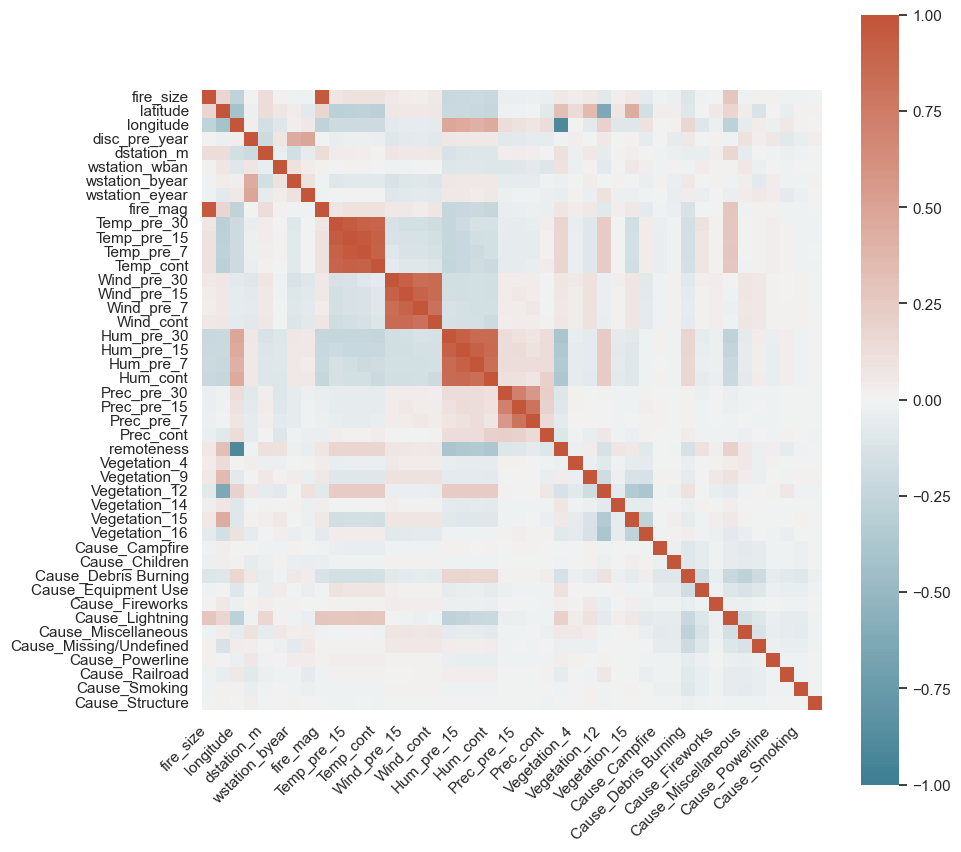

In [63]:
df_numerics_only = df.select_dtypes(include=np.number)

corr = df_numerics_only.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(220, 20, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);
sns.set(rc={'figure.figsize':(15,15)})

In [39]:
### Dealing with missing data
print(len(df))

# drop columns where weather_file is missing in the data, as it wont have the weather situation at that time, so its where ever data is 
#missing we can remove those rows as it wont be useful
index = df[df['weather_file'] == 'File Not Found'].index
df.drop(index, inplace = True)
print(len(df))

51395
37915


In [40]:
# Weather data has a lot of 0 and values some of which may be missing values,
# Mark '0' values in weather columns as Na (to see how many there are) 
# As 0 wont add any value to the data, we are converting to NA and then removing them which will make data set
subset0 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont']
df[subset0] = df[subset0].replace({0:np.nan, '0':np.nan})
print(len(df))

# Mark '-1' as missing
subset_neg1 = ['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont']
df[subset_neg1] = df[subset_neg1].replace({-1:np.nan})

# Drop observations where all weather columns are 0
df = df.dropna(how='all',
                    subset=['Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont',])
print(len(df))
# This leaves us with 38,689 observations  +/- 3,000  to work with (originally we had 50,000)

37915
35683


In [41]:
# fill the 'pre' columns temp wind and humidity with mean values
subset_fill_mean = ['Temp_pre_30','Temp_pre_15','Temp_pre_7', 'Wind_pre_30','Wind_pre_15','Wind_pre_7', 'Hum_pre_30', 'Hum_pre_15','Hum_pre_7']
df[subset_fill_mean] = df[subset_fill_mean].fillna(df[subset_fill_mean].mean())

# Fill NAs in the date of fire containment based on mean values from previous days
for col in ['Temp','Wind','Hum']:
    df[f'{col}_cont'] = df.apply(
        lambda row: (row[f'{col}_pre_7']+row[f'{col}_pre_15']+row[f'{col}_pre_30'])/3 if np.isnan(row[f'{col}_cont']) else row[f'{col}_cont'],
        axis=1)

        

Experiment data  preparation for the models


# Experiment 1 - which will select all the available  features from the dataset



In [47]:
# Experiment 1 - which will select all teh available  features from the dataset
#Features included - variables related to Vegetation,Temperature, Humidity, Wind, Precipitation, cause of  fire, longitude and latitude
# we have 34 variables  for x-variables  to which we are gonna target one y-variable which is fire_size
# selecting features and target variables
X1 = df[['Vegetation_4','remoteness', 'Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
# X1 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]

y = df['fire_size']

#train test split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
df1 = [X1_train, X1_test, y_train, y_test]



Experiment  type 2 :  Include only long, lat, vegetation, cause and pre- weather data, without cont

In [48]:
# which is the data set where I removed the variables  on which the fire is  containining on the day
# removed 4 variables
# selecting features and target variables
X2 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
df2 = [X2_train, X2_test, y_train, y_test]

Experiment 3 - Including only lat, long and weather pre- data

In [49]:
#When I have done the feature importance, I got to know that the cause and vegetation is not that important, so here we removed the 2 
#  selecting features and target variables
X3 = df[['latitude','longitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Wind_pre_30','Wind_pre_15','Wind_pre_7','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Prec_pre_30','Prec_pre_15','Prec_pre_7']]
y = df['fire_size']

#train test split
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)
df3 = [X3_train, X3_test, y_train, y_test]

Experiment 4 :-  with experiment 1 data with normalization


In [50]:
# have done the minMax normalization for the experiment 1 data frame.

df_4 = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
names = df_4.columns

# normalizing data
df_4 = preprocessing.normalize(df_4)
scaled_df = pd.DataFrame(df_4, columns=names)

#train test split
X4_train, X4_test, y_train, y_test = train_test_split(scaled_df, y, test_size=0.2, random_state=42)
df4 = [X4_train, X4_test, y_train, y_test]

Modelling  the above experiments with different models like  decision tree,gradient bosting, random  forest


Decision Tree - Experiment 1


In [51]:
dectr = DecisionTreeRegressor(random_state=0)
dectr.fit(df1[0], df1[2])

predictions = dectr.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 94.29199963430013
R Squared: 0.7398227084553771



Gradient Boosting - Experiment 1



In [52]:
gr_boost = GradientBoostingRegressor()
gr_boost.fit(df1[0], df1[2])

predictions = gr_boost.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))


Mean Absolute Error: 97.42354292019517
R Squared: 0.8155926277215975


In [29]:
rf = RandomForestRegressor()
rf.fit(df1[0], df1[2])

predictions = rf.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))


Mean Absolute Error: 85.75155867799862
R Squared: 0.8586293383220867


Modelling experirments 


In [30]:
# less than 5000
for model in [DecisionTreeRegressor(), GradientBoostingRegressor(), RandomForestRegressor()]:
    for idx,df in enumerate([df1, df2, df3, df4]):
        model.fit(df[0], df[2])
        print(f'{model}; Experiment {idx+1}; Mean Absolute Error:', metrics.mean_absolute_error(df[3], model.predict(df[1])))
        print(f'{model}; Experiment {idx+1}; R Squared:', metrics.r2_score(df[3], model.predict(df[1])))
        print('')


DecisionTreeRegressor(); Experiment 1; Mean Absolute Error: 95.51713343982065
DecisionTreeRegressor(); Experiment 1; R Squared: 0.7324273753762751

DecisionTreeRegressor(); Experiment 2; Mean Absolute Error: 253.17612184531316
DecisionTreeRegressor(); Experiment 2; R Squared: -0.45414574657560935

DecisionTreeRegressor(); Experiment 3; Mean Absolute Error: 264.1528976614824
DecisionTreeRegressor(); Experiment 3; R Squared: -0.5510154945080363

DecisionTreeRegressor(); Experiment 4; Mean Absolute Error: 260.8342705772734
DecisionTreeRegressor(); Experiment 4; R Squared: -0.5183707692995225

GradientBoostingRegressor(); Experiment 1; Mean Absolute Error: 97.58674725441429
GradientBoostingRegressor(); Experiment 1; R Squared: 0.8153139091013593

GradientBoostingRegressor(); Experiment 2; Mean Absolute Error: 251.9940000301519
GradientBoostingRegressor(); Experiment 2; R Squared: 0.17038103469486332

GradientBoostingRegressor(); Experiment 3; Mean Absolute Error: 257.32224092450866
Gradien

KeyboardInterrupt: 

The best performing basemodel is the Random Forest algorithm with R2 of 23%. This is the model we will use for further analysis and improvement.


Fetaure Importance

What features are the most influential in the model?

In [53]:
feature_importances = pd.DataFrame(rf.feature_importances_,
    index = df1[0].columns,columns=['importance']).sort_values('importance',ascending=False)
feature_importances

,importance
remoteness,0.748060
longitude,0.103046
latitude,0.027201
Hum_cont,0.015232
Wind_cont,0.010746
Temp_pre_30,0.008364
Temp_pre_7,0.008201
Temp_cont,0.007874
Hum_pre_15,0.007198
Hum_pre_30,0.006946


In [64]:
# selecting features and target variables
X = df[['Vegetation_9','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Lightning','longitude']]

#train test split
X2_train, X2_test, y2_train, y2_test = train_test_split(X, y, test_size=0.2, random_state=42)




Reevaluate model after deleting least important features


In [66]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor()

# fit the regressor with x and y data
rf_reg.fit(X2_train, y2_train)

predictions = rf_reg.predict(X2_test)
print('Mean Absolute Error:', metrics.mean_absolute_error(y2_test, predictions))
print('R Squared:', metrics.r2_score(y2_test, predictions))

Mean Absolute Error: 240.01852919197074
R Squared: 0.2358296738546155


Hyper-parameter tuning 

In [67]:
rf_reg = RandomForestRegressor()
search_grid={'n_estimators':[50,100,200],'max_depth':[2,5,8,10]}
search=GridSearchCV(estimator=rf_reg,param_grid=search_grid,scoring='neg_mean_absolute_error',n_jobs=1,cv=5, verbose=1)
search.fit(df1[0], df1[2])
print(search.best_score_)
print(search.best_params_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
-80.52136909331561
{'max_depth': 10, 'n_estimators': 200}


In [68]:
# Random Forest Regressor 
rf_reg = RandomForestRegressor(n_estimators = 200, max_depth=10)

# fit the regressor with x and y data
rf_reg.fit(df1[0], df1[2])

predictions = rf_reg.predict(df1[1])
print('Mean Absolute Error:', metrics.mean_absolute_error(df1[3], predictions))
print('R Squared:', metrics.r2_score(df1[3], predictions))

Mean Absolute Error: 82.85766836190824
R Squared: 0.855250626868869



Neural network model


In [69]:
# selecting features and target variables
X = df[['Vegetation_4','Vegetation_9','Vegetation_12','Vegetation_14','Vegetation_15','Vegetation_16','latitude','Temp_pre_30','Temp_pre_15','Temp_pre_7','Temp_cont','Wind_pre_30','Wind_pre_15','Wind_pre_7','Wind_cont','Hum_pre_30', 'Hum_pre_15','Hum_pre_7','Hum_cont','Prec_pre_30','Prec_pre_15','Prec_pre_7','Prec_cont','Cause_Debris Burning','Cause_Equipment Use','Cause_Fireworks','Cause_Lightning','Cause_Miscellaneous','Cause_Missing/Undefined','Cause_Powerline','Cause_Railroad','Cause_Smoking','Cause_Structure', 'longitude']]
y = df['fire_size']

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [71]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))

In [72]:
X_train.shape

(28546, 34)

In [73]:
model = Sequential([
    #normalizer,
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01), kernel_initializer='normal',input_dim = X_train.shape[1]),
    Dense(34, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(64, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(32, activation="relu", kernel_regularizer = regularizers.l2(0.01)),
    Dense(1, activation='linear')
])

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['accuracy','mae']
)

In [75]:
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.15,
    callbacks=[tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=20,
        mode='min',
        restore_best_weights=True
    )]
)

Epoch 1/20
759/759 [==============================] - 1s 1ms/step - loss: 439377.6250 - accuracy: 0.2169 - mae: 240.8279 - val_loss: 428820.7812 - val_accuracy: 0.2167 - val_mae: 249.9530
Epoch 2/20
759/759 [==============================] - 1s 1ms/step - loss: 440359.7188 - accuracy: 0.2167 - mae: 241.4127 - val_loss: 442572.7500 - val_accuracy: 0.2165 - val_mae: 230.8468
Epoch 3/20
759/759 [==============================] - 1s 1ms/step - loss: 439903.5312 - accuracy: 0.2167 - mae: 240.2624 - val_loss: 435113.1562 - val_accuracy: 0.2167 - val_mae: 205.4686
Epoch 4/20
759/759 [==============================] - 1s 1ms/step - loss: 436831.2500 - accuracy: 0.2171 - mae: 239.0090 - val_loss: 442210.8125 - val_accuracy: 0.2167 - val_mae: 283.5364
Epoch 5/20
759/759 [==============================] - 1s 1ms/step - loss: 437985.1875 - accuracy: 0.2170 - mae: 238.0543 - val_loss: 428339.6562 - val_accuracy: 0.2167 - val_mae: 251.2817
Epoch 6/20
759/759 [==============================] - 1s 996

In [76]:
test_loss, test_acc, test_mae = model.evaluate(x=X_test, y=y_test, verbose=0)
print('Mean Absolute Error: {acc:0.3f}'.format(acc=test_mae))
print('accuracy: {acc:0.3f}'.format(acc=test_acc))
print('loss: {acc:0.3f}'.format(acc=test_loss))

Mean Absolute Error: 263.361
accuracy: 0.220
loss: 475755.031


In [77]:
print(f"Average Fire Size: {df.fire_size.mean()}")
print(f"Standard Deviation of Fire Size: {df.fire_size.std()}")


Average Fire Size: 165.5132713465795
Standard Deviation of Fire Size: 728.6857104261225


Classification 


In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35683 entries, 0 to 55360
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fire_name                16376 non-null  object        
 1   fire_size                35683 non-null  float64       
 2   fire_size_class          35683 non-null  object        
 3   latitude                 35683 non-null  float64       
 4   longitude                35683 non-null  float64       
 5   state                    35683 non-null  object        
 6   disc_clean_date          35683 non-null  datetime64[ns]
 7   discovery_month          35683 non-null  object        
 8   disc_date_pre            35683 non-null  object        
 9   disc_pre_year            35683 non-null  int64         
 10  disc_pre_month           35683 non-null  object        
 11  wstation_usaf            35683 non-null  object        
 12  dstation_m               35683 n

In [81]:
df.dropna(axis='rows', how='any', inplace=True)
df.head()

,fire_name,fire_size,fire_size_class,latitude,longitude,state,disc_clean_date,discovery_month,disc_date_pre,disc_pre_year,disc_pre_month,wstation_usaf,dstation_m,wstation_wban,wstation_byear,wstation_eyear,fire_mag,weather_file,Temp_pre_30,Temp_pre_15,Temp_pre_7,Temp_cont,Wind_pre_30,Wind_pre_15,Wind_pre_7,Wind_cont,Hum_pre_30,Hum_pre_15,Hum_pre_7,Hum_cont,Prec_pre_30,Prec_pre_15,Prec_pre_7,Prec_cont,remoteness,Cause,Vegetation_4,Vegetation_9,Vegetation_12,Vegetation_14,Vegetation_15,Vegetation_16,Cause_Campfire,Cause_Children,Cause_Debris Burning,Cause_Equipment Use,Cause_Fireworks,Cause_Lightning,Cause_Miscellaneous,Cause_Missing/Undefined,Cause_Powerline,Cause_Railroad,Cause_Smoking,Cause_Structure
3,WNA 1,1.0,B,39.641400,-119.308300,NV,2005-06-06,Jun,5/7/2005,2005,May,724880,43433.32978,23185,1942,2020,0.1,724880-23185-2005.gz,16.275967,18.996181,18.142564,17.804904,4.054982,3.398329,3.671282,3.708198,44.778429,37.140811,35.353846,39.091029,10.4,7.2,0.0,0.0,0.487447,Debris Burning,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,CRAZY,1.0,B,48.839400,-99.718500,ND,2004-04-19,Apr,3/20/2004,2004,Mar,727675,129109.88140,99999,1936,2020,0.1,727675-99999-2004.gz,4.600950,6.861878,6.053333,5.838721,6.380760,6.334254,6.645333,6.453449,64.606509,55.943038,54.337838,58.295795,12.3,1.8,0.0,0.0,0.291683,Miscellaneous,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
15,ROLSTON,1.0,B,33.988609,-103.135277,NM,1996-02-12,Feb,1/13/1996,1996,Jan,722686,46845.65519,99999,1973,2010,0.1,722686-23008-1996.gz,3.523045,2.536364,8.913095,8.396810,6.245931,6.014404,5.798795,6.062726,38.712707,45.180055,40.493976,33.537604,10.0,8.0,0.0,0.0,0.330323,Missing/Undefined,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
21,TELEPHONE FIRE,5.0,B,33.779575,-96.025915,TX,2010-12-18,Dec,11/18/2010,2010,Nov,742513,38613.87170,99999,2006,2020,0.1,742513-53937-2010.gz,9.156936,6.582006,6.558045,7.834000,4.251752,4.165323,5.025051,4.461400,62.304326,60.116883,53.782222,70.162664,0.0,0.0,0.0,0.0,0.262885,Debris Burning,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
26,STO3573155,2.0,B,35.718900,-92.335000,AR,2014-01-19,Jan,12/20/2013,2013,Dec,720401,16806.87914,99999,2007,2020,0.1,720401-00133-2013.gz,3.490698,16.188459,16.610281,12.096479,1.347442,3.155157,3.136240,2.546280,76.091398,60.977206,59.811044,65.626549,0.0,0.0,0.0,0.0,0.227270,Debris Burning,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0


In [83]:
from sklearn.tree import DecisionTreeClassifier

train_set, test_set = train_test_split(df, test_size=0.30, random_state=568)

print(train_set.info())
print(test_set.info())




<class 'pandas.core.frame.DataFrame'>
Int64Index: 11463 entries, 13079 to 27904
Data columns (total 54 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   fire_name                11463 non-null  object        
 1   fire_size                11463 non-null  float64       
 2   fire_size_class          11463 non-null  object        
 3   latitude                 11463 non-null  float64       
 4   longitude                11463 non-null  float64       
 5   state                    11463 non-null  object        
 6   disc_clean_date          11463 non-null  datetime64[ns]
 7   discovery_month          11463 non-null  object        
 8   disc_date_pre            11463 non-null  object        
 9   disc_pre_year            11463 non-null  int64         
 10  disc_pre_month           11463 non-null  object        
 11  wstation_usaf            11463 non-null  object        
 12  dstation_m               114

I have choosen the following features as I want to predict the magnitude of the fire based on weather conditions.

X = "Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"

Y = "fire_size_class"

Reason

When I was using "fire_size" for the Y feature, I had gotten continuous value error. Hence, I changed to "fire_size_class" as suggested to using discreate values by creating buckets; which my database already has.


Decision Tree 
Training data 


In [84]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
Y = train_set["fire_size_class"]

tree_classifier = DecisionTreeClassifier().fit(X,Y)
print(tree_classifier)

y_pred = tree_classifier.predict(X)
c_matrix = confusion_matrix(Y, y_pred)
print('The confusion Matrix is: ')
print(c_matrix)


DecisionTreeClassifier()
The confusion Matrix is: 
[[7490    2    0    0    1]
 [ 200 2065    0    0    3]
 [  25    6  403    0    0]
 [  22    1    0  273    0]
 [  47    5    2    6  912]]


In [85]:
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(Y, y_pred))
print("Precision: ", precision_score(Y, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(Y, y_pred, average="weighted"))
print("F1 Score: ", f1_score(Y, y_pred, average="weighted"))


The Evalution metrics are as follows: 
Accuracy:  0.9720840966588153
Precision:  0.972866172656583
Sensitivity:  0.9720840966588153
F1 Score:  0.9717493764890638



Gaussian Naive Bayes


In [86]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

# Training Set

X = train_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
Y = train_set["fire_size_class"]

gnb = GaussianNB()
print(gnb.fit(X,Y))

GaussianNB()


In [87]:
y_pred = gnb.predict(X)
c_matrix = confusion_matrix(Y, y_pred)
print("Confusion Metrix: ")
print(c_matrix)

print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(Y, y_pred))
print("Precision: ", precision_score(Y, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(Y, y_pred, average="weighted"))
print("F1 Score: ", f1_score(Y, y_pred, average="weighted"))




Confusion Metrix: 
[[7364   12   35   30   52]
 [2220    5   12   14   17]
 [ 425    0    3    1    5]
 [ 287    1    0    2    6]
 [ 940    1    3    8   20]]
The Evalution metrics are as follows: 
Accuracy:  0.6450318415772486
Precision:  0.5005176972792729
Sensitivity:  0.6450318415772486
F1 Score:  0.5188176519331452


Random Forest classifier

In [91]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

# Training Set
X = test_set[["Temp_pre_7","Wind_pre_7","Hum_pre_7","Prec_pre_7"]]
Y = test_set["fire_size_class"]

rfc = RandomForestClassifier()
print(rfc.fit(X,Y))

y_pred = rfc.predict(X)
c_matrix = confusion_matrix(Y, y_pred)
print("Confusion Metrix: ")
print(c_matrix)

print("The Evalution metrics are as follows: ")
print("Accuracy: ", accuracy_score(Y, y_pred))
print("Precision: ", precision_score(Y, y_pred, average="weighted"))
print("Sensitivity: ", recall_score(Y, y_pred, average="weighted"))
print("F1 Score: ", f1_score(Y, y_pred, average="weighted"))


RandomForestClassifier()
Confusion Metrix: 
[[3130    1    3    1    3]
 [  74  960    0    0    5]
 [  13    0  195    0    3]
 [   2    1    0  108    0]
 [  17    1    0    0  396]]
The Evalution metrics are as follows: 
Accuracy:  0.974760838591492
Precision:  0.9752837102250582
Sensitivity:  0.974760838591492
F1 Score:  0.9745320907143612
